# Product recommendation based on visual similarity


The goal of this experiment is to make a very basic recommender system: for a given fashion product, we want to recommend products that look similar. 

This kind of recommender system is often used when browsing shopping websites. They usually appear on product pages as a "you may also like" section.

The idea behind this recommender system is simple: if a customer is showing interest towards a product by browsing its page, he may also be interested by products that are similar.


## How to proceed ?

We will used a pre-trained CNN model from Keras to extract the image features.

Then we will compute similarities between the different products using the previously extracted image features.

Other type of information can be used for this purpose such as the product category, size, color, etc. if the data is available, but that is not the case here.

### Connect Google Drive to access the dataset and store the model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part-0: Imports Lib for all parts


In [ ]:
# imports

import tensorflow.keras as tf

from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from keras import Input
from keras.layers import Flatten, Dense

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import pickle

import urllib
import cv2
import requests
import json

# Part-1: Train from Google drive folder

## Step-1. Parameters setup

In [ ]:
folderPath='/content/drive/My Drive/Colab Notebooks/product-recommendation/visual-similarity-model/local'
imgs_path='/content/drive/My Drive/Colab Notebooks/product-recommendation/GroceryStoreDataset/'
# imgs_path='/content/drive/My Drive/Colab Notebooks/product dataset/style'
modelfile='model.csv'
filenamesPickle='filenames.pickle'
filePathsPickle='filePaths.pickle'
importedImagesPickle='importedImages.pickle'
importedFileEncodingsPickle='importedFileEncodings.pickle'

In [ ]:
# parameters setup
imgs_model_width, imgs_model_height = 150, 150

nb_closest_images = 5 # number of most similar images to retrieve

## Step-2. load the VGG pre-trained model from Keras

Keras module contains several pre-trained models that can be loaded very easily. 

For our recommender system based on visual similarity, we need to load a Convolutional Neural Network (CNN) that will be able to interpret the image contents.

In this example we will load the VGG16 model trained on imagenet, a big labeled images database.

If we take the whole model, we will get an output containing probabilities to belong to certain classes, but that is not what we want.

We want to retrieve all the information that the model was able to get in the images.

In order to do so, we have to remove the last layers of the CNN which are only used for classes predictions.

In [ ]:
# # Version-1 backup
# # load the model
# vgg_model = vgg16.VGG16(weights="imagenet")

# # remove the last layers in order to get features instead of predictions
# feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# # print the layers of the CNN
# feat_extractor.summary()

In [ ]:
# # Version-2 backup
# model = vgg16.VGG16(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(imgs_model_width, imgs_model_height, 3)))

# x = model.output
# x = Flatten(name='flatten')(x)
# x = Dense(4096,name='fc1')(x)
# x = Dense(4096,name='fc2')(x)
# feat_extractor = Model(model.input, x)
# feat_extractor.summary()

In [ ]:
# Version-3
inputs = tf.layers.Input(shape=(imgs_model_width,imgs_model_height,3))
x = tf.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(inputs)
x = tf.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Flatten(name="flatten")(x)
x = tf.layers.Dense(4096,name="fc1",activation="relu")(x)
prediction = tf.layers.Dense(4096,name="fc2",activation="relu")(x)
# prediction = tf.layers.Dense(units=1000, activation="softmax")(x)

feat_extractor = tf.models.Model(inputs=inputs, outputs=prediction)

feat_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)      

## Step-3. get the images paths

In [ ]:
# files = [os.path.join(imgs_path, x) for x in os.listdir(imgs_path) if "png" in x]
files = [os.path.join(imgs_path, x) for x in os.listdir(imgs_path)]
print("number of images:",len(files))

number of images: 84


In [ ]:
imgs_path='/content/drive/My Drive/Colab Notebooks/product-recommendation/GroceryStoreDataset/'
for x in os.listdir(imgs_path):
    print(x)

Vegetables-Aubergine_Iconic.jpg
Fruits-Apple-Red-Delicious_Iconic.jpg
Fruits-Apple-Pink-Lady_Iconic.jpg
Fruits-Pomegranate_Iconic.jpg
Fruits-Banana_Iconic.jpg
Packages-Sour-Cream-Arla-Sour-Cream_Iconic.jpg
Vegetables-Cucumber_Iconic.jpg
Vegetables-Cabbage_Iconic.jpg
Fruits-Pineapple_Iconic.jpg
Fruits-Melon-Watermelon_Iconic.jpg
Packages-Milk-Arla-Lactose-Medium-Fat-Milk_Iconic.jpg
Vegetables-Pepper-Red-Bell-Pepper_Iconic.jpg
Packages-Yoghurt-Arla-Natural-Yoghurt_Iconic.jpg
Packages-Oatly-Oat-Milk_Iconic.jpg
Fruits-Lemon_Iconic.jpg
Fruits-Pear-Anjou_Iconic.jpg
Packages-Juice-God-Morgon-Orange-Juice_Iconic.jpg
Fruits-Orange_Iconic.jpg
Vegetables-Zucchini_Iconic.jpg
Vegetables-Brown-Cap-Mushroom_Iconic.jpg
Vegetables-Yellow-Onion_Iconic.jpg
Packages-Milk-Garant-Ecological-Medium-Fat-Milk_Iconic.jpg
Vegetables-Leek_Iconic.jpg
Vegetables-Pepper-Green-Bell-Pepper_Iconic.jpg
Packages-Juice-Tropicana-Apple-Juice_Iconic.jpg
Packages-Milk-Arla-Standard-Milk_Iconic.jpg
Packages-Sour-Cream-Arla-Ec

## Step-4. feed one image into the CNN

First we observe what output we get when putting one image into the CNN.

The following steps are:
- loading the image
- preparing the image to feed it into the CNN
- get the CNN output which will correspond to the image features

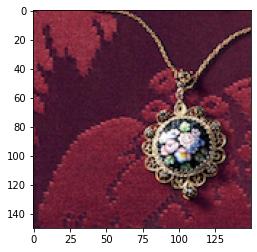

image loaded successfully!


In [ ]:
# load an image in PIL format
original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()
print("image loaded successfully!")

In [ ]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 150, 150, 3)


In [ ]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("features successfully extracted!")
print("number of image features:",img_features.size)
img_features

features successfully extracted!
number of image features: 4096


array([[0.        , 0.13605137, 0.        , ..., 0.3057988 , 0.64183414,
        0.47624242]], dtype=float32)

## Step-5. feed all the images into the CNN

We were able to do the feature extraction process for one image. Now let's do it for all our images!

In [ ]:
# load all the images and prepare them for feeding into the CNN

importedImages = []
filenames=[]
filePaths={}
importedFileEncodings={}

for f in files:
    label=os.path.basename(f)
    filenames.append(label)
    filePaths[label]=f
    print(f)
    original = load_img(f, target_size=(imgs_model_width, imgs_model_height))
    numpy_image = img_to_array(original)
    # print(numpy_image.shape)
    image_batch = np.expand_dims(numpy_image, axis=0)
    # print(image_batch.shape)
    importedFileEncodings[label]=image_batch
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())


/content/drive/My Drive/Colab Notebooks/product dataset/style/2_4_007.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/3_3_001.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/3_5_020.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/2_1_038.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/4_0_038.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/2_1_027.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/3_7_014.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/3_0_050.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/3_7_006.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/3_9_006.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/4_0_032.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/3_2_068.png
/content/drive/My Drive/Colab Notebooks/product dataset/style/3_4_006.png
/content/drive/My Drive/Colab Notebook

In [ ]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(2184, 4096)

## Step-6. compute cosine similarities

Now that we have features for every image, we can compute similarity metrics between every image couple.

We will use here the cosine similarity metric.

In [ ]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=filenames, index=filenames)
cos_similarities_df.head()

,2_4_007.png,3_3_001.png,3_5_020.png,2_1_038.png,4_0_038.png,2_1_027.png,3_7_014.png,3_0_050.png,3_7_006.png,3_9_006.png,4_0_032.png,3_2_068.png,3_4_006.png,4_1_015.png,3_0_045.png,4_2_039.png,3_4_001.png,3_1_011.png,3_4_007.png,4_1_017.png,3_9_023.png,4_2_018.png,2_8_003.png,4_2_053.png,3_0_026.png,2_2_018.png,2_9_014.png,3_2_027.png,4_2_050.png,3_6_036.png,3_6_004.png,4_0_013.png,3_7_026.png,3_2_028.png,2_7_001.png,3_0_022.png,4_2_023.png,2_1_036.png,2_8_011.png,4_0_028.png,...,1_1_015.png,1_6_019.png,2_0_046.png,1_4_036.png,1_6_015.png,0_1_016.png,0_0_070.png,1_5_028.png,2_0_047.png,0_3_008.png,1_2_026.png,1_2_037.png,1_8_001.png,0_1_036.png,1_4_029.png,1_1_006.png,0_3_020.png,1_9_003.png,0_0_036.png,1_7_010.png,0_8_017.png,1_6_005.png,1_6_024.png,1_7_007.png,0_0_044.png,0_8_006.png,0_2_027.png,0_0_098.png,1_1_014.png,1_9_026.png,1_7_012.png,0_1_020.png,0_0_054.png,1_9_027.png,2_1_018.png,0_3_025.png,1_5_018.png,1_2_012.png,0_0_039.png,1_4_035.png
2_4_007.png,1.000000,0.957360,0.963049,0.950676,0.953219,0.969794,0.954335,0.958937,0.956849,0.956091,0.957262,0.954727,0.956199,0.967456,0.956253,0.958512,0.953843,0.966262,0.957535,0.962610,0.954118,0.957739,0.957815,0.955153,0.957227,0.955222,0.953212,0.957406,0.961595,0.960734,0.960105,0.955011,0.962265,0.958089,0.956719,0.948704,0.946914,0.949961,0.959741,0.955625,...,0.953748,0.954892,0.961479,0.963006,0.963355,0.956691,0.960300,0.954042,0.956068,0.962247,0.922631,0.960679,0.955770,0.953236,0.952550,0.959554,0.958995,0.958096,0.955272,0.953244,0.954530,0.959378,0.955026,0.956011,0.945848,0.953414,0.949555,0.955566,0.962518,0.958009,0.951878,0.962139,0.964528,0.954916,0.965577,0.961404,0.960440,0.920012,0.958277,0.957338
3_3_001.png,0.957360,1.000000,0.982511,0.973741,0.986273,0.983560,0.986395,0.983224,0.984192,0.986043,0.980663,0.986600,0.989481,0.984448,0.986659,0.984450,0.989233,0.983729,0.990941,0.969035,0.985921,0.985274,0.986006,0.981812,0.981981,0.982562,0.987607,0.979412,0.970528,0.991639,0.988808,0.986773,0.988722,0.984397,0.992006,0.984734,0.984992,0.972198,0.983413,0.979681,...,0.979314,0.991383,0.983108,0.988172,0.992574,0.971428,0.985595,0.984039,0.981305,0.988078,0.972606,0.973499,0.977919,0.964525,0.987051,0.987997,0.989837,0.985503,0.987780,0.989721,0.982658,0.988817,0.989128,0.990198,0.981032,0.983410,0.981629,0.987815,0.988557,0.988750,0.989064,0.974368,0.987704,0.989960,0.985296,0.988421,0.987720,0.957324,0.988158,0.988795
3_5_020.png,0.963049,0.982511,1.000000,0.980476,0.983474,0.981185,0.982621,0.978536,0.983217,0.980633,0.981157,0.980511,0.982225,0.980795,0.983466,0.977776,0.981674,0.976020,0.983954,0.975821,0.982725,0.977310,0.982081,0.977178,0.981932,0.977971,0.980712,0.973262,0.969597,0.984963,0.984676,0.980952,0.985342,0.982619,0.984218,0.980900,0.977440,0.978785,0.980596,0.982092,...,0.975922,0.983032,0.982750,0.979916,0.985818,0.970911,0.981078,0.983980,0.983424,0.981644,0.959704,0.975163,0.971758,0.967690,0.978953,0.985289,0.984049,0.984414,0.982148,0.981675,0.981380,0.983192,0.981266,0.982158,0.978085,0.978297,0.976011,0.982522,0.984519,0.982806,0.980489,0.975398,0.984714,0.982687,0.983559,0.986801,0.984908,0.948709,0.982395,0.982176
2_1_038.png,0.950676,0.973741,0.980476,1.000000,0.980296,0.974518,0.977320,0.970366,0.980970,0.975366,0.979219,0.978850,0.976542,0.973366,0.979085,0.974902,0.976098,0.963662,0.976612,0.972164,0.975675,0.973981,0.975868,0.968361,0.982002,0.973402,0.973282,0.969052,0.958925,0.974032,0.977612,0.974151,0.976937,0.973676,0.976833,0.976997,0.980913,0.978486,0.978049,0.981530,...,0.975073,0.976427,0.976112,0.969189,0.978485,0.966773,0.975783,0.980053,0.982561,0.974212,0.964892,0.964169,0.971027,0.967531,0.972827,0.980673,0.976929,0.981447,0.975906,0.975380,0.982743,0.977632,0.975546,0.975672,0.973858,0.975530,0.966917,0.975321,0.980089,0.975015,0.977205,0.974722,0.977548,0.976952,0.974032,0.977909,0.978609,0.958925,0.975359,0.978286
4_0_038.png,0.953219,0.986273,0.983474,0.980296,1.000000,0.983777,0.996460,0.988621,0.99591

## Step-7. Save to Model

In [ ]:
with open(os.path.join(folderPath,filenamesPickle), 'wb') as f:
    pickle.dump(filenames, f)

with open(os.path.join(folderPath,filePathsPickle), 'wb') as f:
    pickle.dump(filePaths, f)

with open(os.path.join(folderPath,importedImagesPickle), 'wb') as f:
    pickle.dump(importedImages, f)

with open(os.path.join(folderPath,importedFileEncodingsPickle), 'wb') as f:
    pickle.dump(importedFileEncodings, f)


cos_similarities_df.to_csv(os.path.join(folderPath,modelfile))

## Step-8. Load from Model

In [ ]:
with open(os.path.join(folderPath,filenamesPickle), 'rb') as f:
    filename = pickle.load(f)
print(type(filename))

with open(os.path.join(folderPath,filePathsPickle), 'rb') as f:
    filePath = pickle.load(f)
print(type(filePath))

with open(os.path.join(folderPath,importedFileEncodingsPickle), 'rb') as f:
    importedFileEncoding = pickle.load(f)
print(type(importedFileEncoding))

model=pd.read_csv(os.path.join(folderPath,modelfile), index_col=[0])
model.head()

<class 'list'>
<class 'dict'>
<class 'dict'>


,2_4_007.png,3_3_001.png,3_5_020.png,2_1_038.png,4_0_038.png,2_1_027.png,3_7_014.png,3_0_050.png,3_7_006.png,3_9_006.png,4_0_032.png,3_2_068.png,3_4_006.png,4_1_015.png,3_0_045.png,4_2_039.png,3_4_001.png,3_1_011.png,3_4_007.png,4_1_017.png,3_9_023.png,4_2_018.png,2_8_003.png,4_2_053.png,3_0_026.png,2_2_018.png,2_9_014.png,3_2_027.png,4_2_050.png,3_6_036.png,3_6_004.png,4_0_013.png,3_7_026.png,3_2_028.png,2_7_001.png,3_0_022.png,4_2_023.png,2_1_036.png,2_8_011.png,4_0_028.png,...,1_1_015.png,1_6_019.png,2_0_046.png,1_4_036.png,1_6_015.png,0_1_016.png,0_0_070.png,1_5_028.png,2_0_047.png,0_3_008.png,1_2_026.png,1_2_037.png,1_8_001.png,0_1_036.png,1_4_029.png,1_1_006.png,0_3_020.png,1_9_003.png,0_0_036.png,1_7_010.png,0_8_017.png,1_6_005.png,1_6_024.png,1_7_007.png,0_0_044.png,0_8_006.png,0_2_027.png,0_0_098.png,1_1_014.png,1_9_026.png,1_7_012.png,0_1_020.png,0_0_054.png,1_9_027.png,2_1_018.png,0_3_025.png,1_5_018.png,1_2_012.png,0_0_039.png,1_4_035.png
2_4_007.png,1.000000,0.957360,0.963049,0.950676,0.953219,0.969794,0.954335,0.958937,0.956849,0.956091,0.957262,0.954727,0.956199,0.967456,0.956253,0.958512,0.953843,0.966262,0.957535,0.962610,0.954118,0.957739,0.957815,0.955153,0.957227,0.955222,0.953212,0.957406,0.961595,0.960734,0.960105,0.955011,0.962265,0.958089,0.956719,0.948704,0.946914,0.949961,0.959741,0.955625,...,0.953748,0.954892,0.961479,0.963006,0.963355,0.956691,0.960300,0.954042,0.956068,0.962247,0.922631,0.960679,0.955770,0.953235,0.952550,0.959554,0.958995,0.958096,0.955272,0.953244,0.954530,0.959378,0.955026,0.956011,0.945848,0.953414,0.949555,0.955566,0.962518,0.958009,0.951878,0.962139,0.964528,0.954916,0.965577,0.961404,0.960440,0.920011,0.958277,0.957338
3_3_001.png,0.957360,1.000000,0.982511,0.973741,0.986273,0.983560,0.986395,0.983224,0.984192,0.986043,0.980663,0.986600,0.989481,0.984448,0.986659,0.984450,0.989233,0.983729,0.990941,0.969035,0.985921,0.985275,0.986006,0.981811,0.981981,0.982562,0.987607,0.979412,0.970528,0.991639,0.988808,0.986773,0.988722,0.984397,0.992006,0.984734,0.984992,0.972198,0.983413,0.979682,...,0.979314,0.991383,0.983108,0.988172,0.992574,0.971428,0.985595,0.984039,0.981305,0.988078,0.972606,0.973499,0.977919,0.964525,0.987051,0.987997,0.989837,0.985503,0.987780,0.989721,0.982658,0.988817,0.989128,0.990199,0.981032,0.983410,0.981629,0.987815,0.988557,0.988750,0.989063,0.974368,0.987704,0.989960,0.985296,0.988421,0.987720,0.957324,0.988158,0.988795
3_5_020.png,0.963049,0.982511,1.000000,0.980476,0.983474,0.981185,0.982621,0.978536,0.983217,0.980633,0.981157,0.980511,0.982225,0.980795,0.983466,0.977776,0.981674,0.976020,0.983954,0.975821,0.982725,0.977310,0.982081,0.977178,0.981932,0.977971,0.980712,0.973262,0.969597,0.984962,0.984676,0.980952,0.985342,0.982619,0.984218,0.980900,0.977440,0.978784,0.980596,0.982092,...,0.975922,0.983032,0.982750,0.979916,0.985818,0.970911,0.981078,0.983980,0.983425,0.981644,0.959703,0.975163,0.971758,0.967690,0.978953,0.985289,0.984049,0.984414,0.982148,0.981675,0.981380,0.983192,0.981267,0.982158,0.978085,0.978297,0.976011,0.982522,0.984519,0.982806,0.980489,0.975398,0.984714,0.982687,0.983559,0.986801,0.984908,0.948709,0.982395,0.982176
2_1_038.png,0.950676,0.973741,0.980476,1.000000,0.980296,0.974518,0.977320,0.970366,0.980970,0.975366,0.979219,0.978850,0.976542,0.973366,0.979085,0.974902,0.976098,0.963662,0.976612,0.972164,0.975675,0.973981,0.975868,0.968361,0.982002,0.973402,0.973282,0.969052,0.958925,0.974032,0.977612,0.974151,0.976938,0.973676,0.976833,0.976997,0.980913,0.978486,0.978049,0.981530,...,0.975073,0.976427,0.976112,0.969189,0.978485,0.966773,0.975783,0.980053,0.982561,0.974212,0.964892,0.964169,0.971027,0.967531,0.972827,0.980673,0.976930,0.981447,0.975906,0.975380,0.982743,0.977632,0.975546,0.975672,0.973858,0.975530,0.966917,0.975321,0.980089,0.975015,0.977205,0.974722,0.977548,0.976953,0.974032,0.977909,0.978609,0.958925,0.975359,0.978286
4_0_038.png,0.953219,0.986273,0.983474,0.980296,1.000000,0.983777,0.996460,0.988621,0.99591

## Step-9.1. retrieve most similar products from File Path

The final step is to implement a function that, for any given product, returns the visually most similar products.

In [ ]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):
    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(filePath[given_img], target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = model[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = model[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    # print(closest_imgs,closest_imgs_scores)

    for i in range(0,len(closest_imgs)):
        original = load_img(filePath[closest_imgs[i]], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

## Step-9.2. retrieve most similar products from File Encodings

The final step is to implement a function that, for any given product, returns the visually most similar products.

In [ ]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):
    print("-----------------------------------------------------------------------")
    print("original product:")
    encoding=importedFileEncoding[given_img]
    original = Image.fromarray(encoding[0,:,:,:].astype(np.uint8))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = model[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = model[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    # print(closest_imgs,closest_imgs_scores)

    for i in range(0,len(closest_imgs)):
        encoding=importedFileEncoding[closest_imgs[i]]
        original = Image.fromarray(encoding[0,:,:,:].astype(np.uint8))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])


## Step-10. Find Recommendations

-----------------------------------------------------------------------
original product:


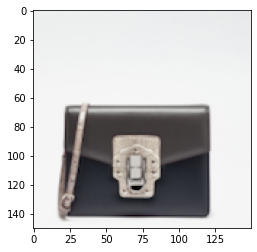

-----------------------------------------------------------------------
most similar products:


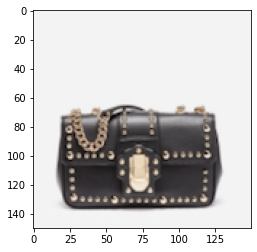

similarity score :  0.99429274


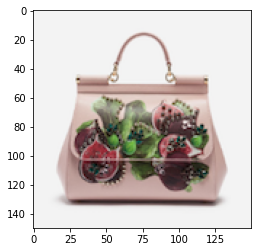

similarity score :  0.99282676


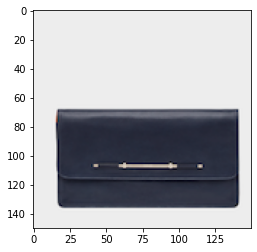

similarity score :  0.99264437


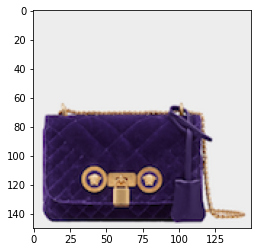

similarity score :  0.99241257


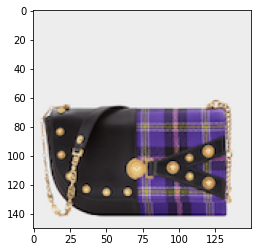

similarity score :  0.9921226999999999


In [ ]:
retrieve_most_similar_products(filename[25])

# Part-2: Displaying image if extended dimensions of numpy array Demo

In [ ]:
original = load_img('/content/drive/My Drive/Colab Notebooks/product-recommendation/GroceryStoreDataset/Fruits-Apple-Golden-Delicious_Iconic.jpg', target_size=(imgs_model_width, imgs_model_height))
numpy_image = img_to_array(original)
print(numpy_image.shape)
image_batch = np.expand_dims(numpy_image, axis=0)
original

In [ ]:
print(image_batch.shape)
img =  Image.fromarray(image_batch[0,:,:,:].astype(np.uint8))
img

# Part-3: Grab image from URL and convert to numpy array demo 

In [ ]:
def _grab_image(path=None, stream=None, url=None):
    if path is not None:
        image = cv2.imread(path)
    else:
        if url is not None:
            resp = urllib.request.urlopen(url)
            data = resp.read()
        elif stream is not None:
            data = stream.read()
        image = np.asarray(bytearray(data), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(300,300))
    return image

In [ ]:
url='https://drive.google.com/uc?id=19j3A4tD-szHsHF2-SWPLU2lziFqeB0Y3'
image = _grab_image(url=url)
print(image.shape)
images=Image.fromarray(image.astype(np.uint8))
images

# Part-4: Load Image from API for training

## Step-1. Import details from API URL

In [ ]:
domain = 'https://dms24-v6.loca.lt'
fileurl = domain + '/api/products/dataset/images/'

resp=requests.get(fileurl)
json_data=resp.json()
print(type(json_data),len(json_data))

<class 'dict'> 2184


In [ ]:
imageEncodingsMap=dict()
imageEncodings=list()
filenames=list()

## Step-2. Parameters Setup

In [ ]:
folderAPIPath='/content/drive/My Drive/Colab Notebooks/product-recommendation/visual-similarity-model/API'
modelfile='model.csv'
filenamesPickle='filenames.pickle'
imageEncodingsPickle='imageEncodings.pickle'
imageEncodingsMapPickle='imageEncodingsMap.pickle'

imgs_model_width, imgs_model_height = 150, 150
nb_closest_images = 3 # number of most similar images to retrieve

## Step-3. Setup VGG-16 ImageNet Model 

In [ ]:
# Model
inputs = tf.layers.Input(shape=(imgs_model_width,imgs_model_height,3))
x = tf.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(inputs)
x = tf.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = tf.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = tf.layers.Flatten(name="flatten")(x)
x = tf.layers.Dense(4096,name="fc1",activation="relu")(x)
prediction = tf.layers.Dense(4096,name="fc2",activation="relu")(x)
# prediction = tf.layers.Dense(units=1000, activation="softmax")(x)

feat_extractor = tf.models.Model(inputs=inputs, outputs=prediction)

feat_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 128)      

## Step-4: Function to grab image from URL and convert to numpy array

In [ ]:
def _grab_image(path=None, stream=None, url=None):
    if path is not None:
        image = cv2.imread(path)
    else:
        if url is not None:
            resp = urllib.request.urlopen(url)
            data = resp.read()
        elif stream is not None:
            data = stream.read()
        image = np.asarray(bytearray(data), dtype="uint8")
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(imgs_model_width,imgs_model_height))
    return image

## Step-5. Download and Preprocess Images

In [ ]:
for key,val in json_data.items():
    print(key,domain+val)
    while(True):
        try:
            numpy_image=_grab_image(url=domain+val)
            break
        except Exception as e:
            print(e)
    imageEncodingsMap[key]=numpy_image
    # print(numpy_image.shape)
    image_batch = np.expand_dims(numpy_image, axis=0)
    # print(image_batch.shape)
    imageEncodings.append(image_batch)
    filenames.append(key)
    image_batch = np.expand_dims(numpy_image, axis=0)
    

images = np.vstack(imageEncodings)

processed_imgs = preprocess_input(images.copy())

https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_001.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_002.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_003.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_004.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_005.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_006.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_007.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_008.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_009.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_010.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_011.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_012.png
https://dms24-v6.loca.lt/mediafiles/media/public/products/main/1_8_013.png
https://dms24-v6.loca.lt/

## Step-6. Display Preprocessed Image

In [ ]:
# # display
# def show_images(images):
#     n = len(images)
#     row=10
    
#     for i, (k, v) in enumerate(images.items()):
#         plot=plt.subplot((n/row)+1, row, i + 1)
#         plot.set_title("image-"+str(k))
#         plt.imshow(images[k])
#     plt.show()

# plt.figure(figsize = (25, 25))
# new=dict()
# for key,val in imageEncodingsMap.items():
#     new[key]=Image.fromarray(val.astype(np.uint8))
# show_images(new)

## Step-7. Feed Preprocessed images to the model and extract features

In [ ]:
# extract the images features

imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

features successfully extracted!


(2184, 4096)

## Step-8. Compute Cosine Similarities

In [ ]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=filenames, index=filenames)
cos_similarities_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2145,2146,2147,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2183,2184
1,1.000000,0.973756,0.979579,0.970205,0.968881,0.950788,0.978589,0.973102,0.966003,0.976329,0.973846,0.977849,0.983345,0.975290,0.950145,0.952090,0.964519,0.964817,0.975958,0.963495,0.972883,0.972480,0.963718,0.964631,0.966494,0.965738,0.965922,0.968814,0.960008,0.966887,0.972050,0.963857,0.970943,0.972975,0.965485,0.966925,0.970985,0.981210,0.966146,0.967895,...,0.966918,0.968645,0.965078,0.966451,0.963437,0.955226,0.967643,0.962433,0.965451,0.961924,0.955020,0.960585,0.960415,0.964253,0.952299,0.957992,0.953642,0.963445,0.963951,0.955856,0.953321,0.958771,0.960518,0.961682,0.965203,0.963578,0.962635,0.964661,0.964182,0.959889,0.956647,0.961661,0.962197,0.960638,0.958387,0.958354,0.958499,0.954263,0.964355,0.955002
2,0.973756,1.000000,0.980050,0.977150,0.980396,0.938715,0.978695,0.982187,0.989649,0.978393,0.975399,0.972862,0.975029,0.976678,0.961984,0.961065,0.987904,0.981448,0.967453,0.987297,0.981430,0.987531,0.976843,0.979282,0.978964,0.982731,0.990901,0.990310,0.985098,0.990901,0.980183,0.988361,0.973061,0.977768,0.978143,0.978107,0.975474,0.976107,0.980877,0.979435,...,0.973159,0.977853,0.973188,0.977150,0.979537,0.967241,0.974239,0.979161,0.983843,0.981734,0.974412,0.981630,0.969886,0.974320,0.962517,0.963689,0.962488,0.970090,0.970080,0.962253,0.966801,0.972373,0.981401,0.982467,0.969959,0.971174,0.973906,0.968095,0.971549,0.977542,0.981125,0.959402,0.959892,0.965283,0.971541,0.979016,0.980896,0.969001,0.967166,0.967446
3,0.979579,0.980050,1.000000,0.980946,0.972028,0.944113,0.985818,0.982319,0.978981,0.986432,0.977203,0.974409,0.984919,0.984816,0.958146,0.958374,0.977403,0.972367,0.978682,0.973309,0.982832,0.979286,0.966587,0.971564,0.975439,0.970126,0.977893,0.977506,0.975745,0.977078,0.984748,0.976177,0.974971,0.976355,0.969523,0.976239,0.981208,0.981393,0.971685,0.971593,...,0.973097,0.976393,0.971945,0.974499,0.972137,0.961824,0.974208,0.971663,0.975457,0.971112,0.962551,0.970338,0.967362,0.972962,0.964084,0.963045,0.960322,0.970673,0.972822,0.961224,0.962670,0.966097,0.972510,0.973650,0.972397,0.971350,0.970418,0.971580,0.971282,0.969681,0.969367,0.965739,0.966367,0.967389,0.964492,0.969245,0.968541,0.959659,0.965787,0.962795
4,0.970205,0.977150,0.980946,1.000000,0.968443,0.940414,0.977220,0.974477,0.980272,0.978972,0.970253,0.967986,0.973358,0.975909,0.961207,0.959294,0.977847,0.971166,0.976102,0.970878,0.974429,0.977412,0.965901,0.970379,0.969977,0.965742,0.978761,0.978087,0.978276,0.975739,0.982368,0.977696,0.971973,0.969325,0.965648,0.976938,0.986025,0.970701,0.969786,0.967786,...,0.974656,0.977330,0.975617,0.977639,0.975853,0.964412,0.979727,0.972271,0.977051,0.969349,0.964833,0.969510,0.966927,0.974356,0.964703,0.964871,0.956502,0.975709,0.976774,0.963246,0.965250,0.964814,0.970729,0.973234,0.975059,0.971446,0.971645,0.969825,0.972813,0.970347,0.968211,0.965841,0.969886,0.969035,0.965738,0.968053,0.968007,0.961377,0.964714,0.967501
5,0.968881,0.980396,0.972028,0.968443,1.000000,0.939646,0.977223,0.970403,0.981156,0.977502,0.967595,0.964682,0.966158,0.977733,0.963009,0.964104,0.983064,0.975533,0.962673,0.978520,0.969119,0.981704,0.970381,0.975117,0.975298,0.973810,0.981375,0.981761,0.981174,0.981616,0.976845,0.982889,0.972600,0.975429,0.974252,0.969925,0.970334,0.970871,0.977021,0.973601,...,0.967074,0.970048,0.968132,0.968903,0.970007,0.961138,0.966420,0.971862,0.974404,0.972306,0.963240,0.972079,0.962117,0.969154,0.960172,0.959730,0.960429,0.962127,0.969368,0.960429,0.959252,0.962722,0.977512,0.980859,0.967021,0.967568,0.967366,0.966323,0.967254,0.970792,0.975896,0.958816,0.956060,0.962190,0.962549,0.974414,0.968840,0.959574,0.970790,0.961467


## Step-9. Save Model and required Data

In [ ]:
with open(os.path.join(folderAPIPath,filenamesPickle), 'wb') as f:
    pickle.dump(filenames, f)

with open(os.path.join(folderAPIPath,imageEncodingsPickle), 'wb') as f:
    pickle.dump(imageEncodings, f)

with open(os.path.join(folderAPIPath,imageEncodingsMapPickle), 'wb') as f:
    pickle.dump(imageEncodingsMap, f)

cos_similarities_df.to_csv(os.path.join(folderAPIPath,modelfile))

## Step-10. Load Model and required Data

In [ ]:
with open(os.path.join(folderAPIPath,filenamesPickle), 'rb') as f:
    filename = pickle.load(f)
print(type(filename))

with open(os.path.join(folderAPIPath,imageEncodingsMapPickle), 'rb') as f:
    imageEncodingsMap = pickle.load(f)
print(type(imageEncodingsMap))

model=pd.read_csv(os.path.join(folderAPIPath,modelfile), index_col=[0])
model.head()

<class 'list'>
<class 'dict'>


,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162
82,1.000000,0.984065,0.989266,0.972102,0.979951,0.972643,0.975681,0.969719,0.981253,0.972532,0.973841,0.977033,0.978399,0.975427,0.977261,0.964386,0.983820,0.971159,0.968878,0.964033,0.994018,0.978397,0.985017,0.973753,0.971910,0.982442,0.981327,0.975183,0.963742,0.972260,0.976473,0.975829,0.971165,0.973474,0.975145,0.973214,0.973451,0.971218,0.971991,0.978156,...,0.966500,0.966301,0.967996,0.970040,0.965386,0.977528,0.961958,0.963803,0.974174,0.976005,0.973826,0.973033,0.962598,0.962459,0.967996,0.974234,0.973049,0.975000,0.974962,0.972207,0.974971,0.979512,0.971697,0.970925,0.985654,0.973774,0.970218,0.981792,0.982169,0.981238,0.983569,0.982288,0.981158,0.970966,0.969851,0.973906,0.973065,0.969949,0.978643,0.967140
83,0.984065,1.000000,0.984422,0.983624,0.988433,0.978696,0.969818,0.966206,0.973192,0.970614,0.984840,0.981333,0.978313,0.972246,0.984904,0.977133,0.986491,0.965164,0.966008,0.976212,0.982789,0.973870,0.976608,0.966207,0.971599,0.976896,0.985758,0.971629,0.954980,0.963595,0.966948,0.968388,0.963386,0.965924,0.969085,0.965787,0.964839,0.963119,0.963922,0.971348,...,0.957846,0.957155,0.956511,0.958766,0.963312,0.966484,0.951286,0.955615,0.962723,0.964932,0.963353,0.962015,0.954812,0.955630,0.956511,0.965366,0.962166,0.963888,0.965602,0.968480,0.968793,0.975873,0.966292,0.963260,0.975961,0.966307,0.960642,0.979417,0.979257,0.981306,0.983034,0.977515,0.977227,0.967080,0.965090,0.968252,0.972095,0.968287,0.974503,0.960238
84,0.989266,0.984422,1.000000,0.978494,0.986039,0.977378,0.966042,0.966426,0.973520,0.969721,0.977778,0.974508,0.971595,0.967294,0.978534,0.971937,0.984206,0.965319,0.964888,0.972278,0.988192,0.973081,0.977772,0.962898,0.971402,0.987335,0.978708,0.972039,0.951011,0.962520,0.966583,0.967241,0.961611,0.965041,0.967671,0.962353,0.962216,0.960493,0.961479,0.969798,...,0.953831,0.953717,0.954727,0.957161,0.956395,0.966914,0.948870,0.952615,0.962518,0.964686,0.960279,0.959229,0.950680,0.951027,0.954727,0.963162,0.961098,0.962631,0.963006,0.967334,0.969896,0.974547,0.964585,0.961572,0.976386,0.965664,0.958704,0.987184,0.985765,0.988580,0.983111,0.978996,0.976288,0.967695,0.966149,0.968293,0.971698,0.965787,0.976368,0.959244
85,0.972102,0.983624,0.978494,1.000000,0.990371,0.975992,0.963444,0.965033,0.967016,0.967870,0.988943,0.980160,0.973635,0.964965,0.984210,0.990852,0.984250,0.964450,0.966090,0.987024,0.972661,0.964911,0.967846,0.957687,0.966015,0.972926,0.982265,0.970885,0.948345,0.958425,0.960503,0.962189,0.958375,0.960526,0.963099,0.958738,0.958280,0.956382,0.958034,0.964038,...,0.951661,0.951408,0.950513,0.952455,0.955558,0.959746,0.946066,0.949676,0.955751,0.957765,0.954423,0.952506,0.948403,0.949024,0.950513,0.956744,0.954422,0.956303,0.957759,0.963606,0.963140,0.973935,0.961050,0.956125,0.964945,0.959858,0.953218,0.974227,0.976583,0.981992,0.982537,0.973300,0.973051,0.962413,0.960023,0.965380,0.968114,0.965622,0.966294,0.954902
86,0.979951,0.988433,0.986039,0.990371,1.000000,0.979814,0.963844,0.963960,0.968858,0.968131,0.987724,0.979586,0.973689,0.966056,0.984876,0.986983,0.987590,0.964238,0.965618,0.985664,0.979643,0.966720,0.970874,0.958735,0.968640,0.979792,0.984946,0.971516,0.948157,0.957694,0.960993,0.963511,0.959423,0.962044,0.964985,0.959783,0.959483,0.956840,0.958800,0.966142,...,0.951374,0.951283,0.950729,0.953377,0.952425,0.961029,0.945071,0.948696,0.956326,0.959063,0.955328,0.953361,0.946525,0.947359,0.950729,0.957399,0.955709,0.957584,0.959620,0.963873,0.965655,0.977579,0.960236,0.956668,0.969293,0.960446,0.953258,0.977797,0.983262,0.985368,0.985317,0.977432,0.976420,0.964342,0.960441,0.965399,0.970307,0.964695,0.970002,0.953579


## Step-11. Retrieve most similar products from File Encodings

In [ ]:
# function to retrieve the most similar products for a given one

def retrieve_most_similar_products(given_img):
    print("-----------------------------------------------------------------------")
    print("original product:")
    encoding=imageEncodingsMap[given_img]
    original = Image.fromarray(encoding.astype(np.uint8))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    # closest_imgs = model[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    # closest_imgs_scores = model[given_img].sort_values(ascending=False)[1:nb_closest_images+1]
    closest_imgs = model[given_img].sort_values(ascending=False)[1:].index
    closest_imgs_scores = model[given_img].sort_values(ascending=False)[1:]
    # print(closest_imgs)
    # print(closest_imgs_scores)

    for i in range(0,nb_closest_images):
        encoding=imageEncodingsMap[str(closest_imgs[i])]
        original = Image.fromarray(encoding.astype(np.uint8))
        plt.imshow(original)
        plt.show()
        print("product : ",closest_imgs[i])
        print("similarity score : ",closest_imgs_scores[(closest_imgs[i])])


## Step-12. Find Recommendations

-----------------------------------------------------------------------
original product:


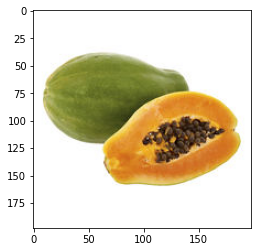

-----------------------------------------------------------------------
most similar products:


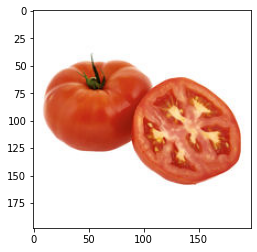

product :  158
similarity score :  0.9891481


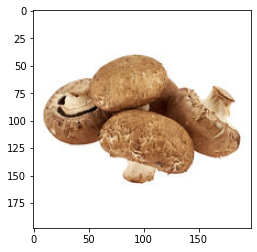

product :  143
similarity score :  0.98645836


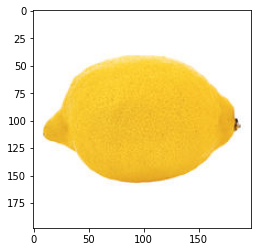

product :  90
similarity score :  0.9841369000000001


In [ ]:
retrieve_most_similar_products("99")

In [ ]:
retrieve_most_similar_products(filename[50])

# Conclusion
We saw above that this very basic recommender system is able to find similar products accurately: most of the time the retrieved products have the same purpose and even look very similar.

This could be incorporated directly into a website using a web framework such as Flask.